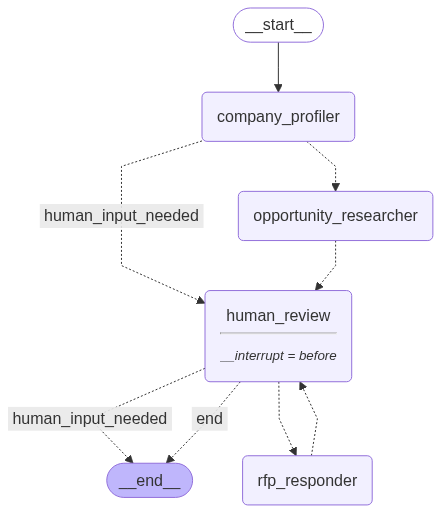

🤖 RFP Assistant Started!

Simulating user input...

User Input: 
    Company: TechSolutions Inc.
    We specialize in cloud migration, API development, security compliance, and healthcare IT.
    Team size: 15 professionals
    Located in Ontario
    Previous experience with Health Canada projects
    


/var/folders/kq/tztc1qnx6lld7r6kmwfmpgw40000gn/T/ipykernel_58771/1852646551.py:172: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  opportunities = search_canadian_rfps(search_query, province)


AttributeError: 'str' object has no attribute 'parent_run_id'

In [2]:
import os
from typing import Dict, List, Any, Optional, TypedDict, Annotated
from datetime import datetime, timedelta
import json
import asyncio

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
import operator

# State definition for the RFP Assistant
class RFPAssistantState(TypedDict):
    messages: Annotated[List[Dict], operator.add]
    company_profile: Optional[Dict[str, Any]]
    opportunities: List[Dict[str, Any]]
    selected_opportunity: Optional[Dict[str, Any]]
    analysis_results: List[Dict[str, Any]]
    rfp_responses: Dict[str, Any]
    current_step: str
    human_feedback: Optional[str]
    iteration_count: int

# Mock data sources (in production, replace with real APIs)
MOCK_OPPORTUNITIES = [
    {
        "id": "RFP-2024-001",
        "title": "Digital Transformation Services for Healthcare",
        "agency": "Health Canada",
        "province": "ON",
        "value": "$2.5M - $5M CAD",
        "close_date": "2024-12-15",
        "requirements": ["Cloud migration", "API development", "Security compliance", "Healthcare experience"],
        "description": "Seeking comprehensive digital transformation services for modernizing healthcare data systems.",
        "source": "SAP (System for Award and Procurement)",
        "url": "https://sap.gov.ca/rfp-2024-001"
    },
    {
        "id": "RFP-2024-002", 
        "title": "AI-Powered Data Analytics Platform",
        "agency": "Statistics Canada",
        "province": "ON",
        "value": "$1M - $3M CAD",
        "close_date": "2024-11-30",
        "requirements": ["Machine Learning", "Data visualization", "Python/R", "Statistical analysis"],
        "description": "Development of AI-powered analytics platform for census data processing.",
        "source": "MERX",
        "url": "https://merx.com/rfp-2024-002"
    },
    {
        "id": "RFP-2024-003",
        "title": "Cybersecurity Assessment Services",
        "agency": "Public Safety Canada",
        "province": "BC",
        "value": "$500K - $1.5M CAD",
        "close_date": "2024-12-01",
        "requirements": ["Penetration testing", "Security audits", "Compliance frameworks", "Risk assessment"],
        "description": "Comprehensive cybersecurity assessment for critical infrastructure systems.",
        "source": "BuyandSell.gc.ca",
        "url": "https://buyandsell.gc.ca/rfp-2024-003"
    }
]

# Tools for the RFP Assistant
@tool
def search_canadian_rfps(query: str, province: str = "", value_range: str = "") -> List[Dict]:
    """
    Search for Canadian RFPs and procurement opportunities.
    
    Args:
        query: Search terms related to services/technology
        province: Optional province filter (ON, BC, QC, etc.)
        value_range: Optional contract value range
    """
    # In production, this would integrate with real APIs like:
    # - SAP (System for Award and Procurement)
    # - MERX
    # - BuyandSell.gc.ca
    # - Provincial procurement sites
    
    filtered_opps = []
    for opp in MOCK_OPPORTUNITIES:
        if query.lower() in opp['title'].lower() or query.lower() in opp['description'].lower():
            if not province or opp['province'] == province.upper():
                filtered_opps.append(opp)
    
    return filtered_opps

@tool 
def calculate_fit_score(company_capabilities: List[str], rfp_requirements: List[str]) -> Dict:
    """
    Calculate how well a company fits an RFP based on capabilities vs requirements.
    
    Args:
        company_capabilities: List of company's technical capabilities
        rfp_requirements: List of RFP requirements
    """
    matches = set(company_capabilities) & set(rfp_requirements)
    fit_percentage = (len(matches) / len(rfp_requirements)) * 100 if rfp_requirements else 0
    
    return {
        "fit_percentage": round(fit_percentage, 1),
        "matched_requirements": list(matches),
        "missing_requirements": [req for req in rfp_requirements if req not in company_capabilities],
        "recommendation": "High fit" if fit_percentage >= 70 else "Medium fit" if fit_percentage >= 40 else "Low fit"
    }

@tool
def generate_rfp_section(section_name: str, requirements: str, company_info: Dict) -> str:
    """
    Generate a specific section of an RFP response.
    
    Args:
        section_name: Name of the RFP section (e.g., "Technical Approach", "Team Structure")
        requirements: Requirements for this section
        company_info: Company information and capabilities
    """
    # This would use a more sophisticated prompt and company knowledge base
    templates = {
        "executive_summary": f"""
        Based on {company_info.get('name', 'our company')}'s expertise in {', '.join(company_info.get('capabilities', []))}, 
        we propose a comprehensive solution addressing the key requirements: {requirements}.
        Our approach leverages proven methodologies and experienced professionals to deliver exceptional results.
        """,
        "technical_approach": f"""
        Our technical approach incorporates industry best practices and leverages our expertise in {', '.join(company_info.get('capabilities', []))}.
        We will address the requirements through: {requirements}
        Our methodology ensures scalable, secure, and maintainable solutions.
        """,
        "team_structure": f"""
        Our project team consists of certified professionals with extensive experience in relevant technologies.
        Team size: {company_info.get('team_size', 'TBD')} professionals
        Key roles include project management, technical leads, and subject matter experts.
        """
    }
    
    return templates.get(section_name.lower().replace(" ", "_"), f"Section content for {section_name}: {requirements}")

# LangGraph nodes
def company_profiler_node(state: RFPAssistantState):
    """Node to collect and structure company information"""
    messages = state.get("messages", [])
    
    if not state.get("company_profile"):
        return {
            "messages": messages + [{
                "role": "assistant", 
                "content": "Let's start by building your company profile. Please provide:\n1. Company name\n2. Core capabilities/services\n3. Team size\n4. Previous relevant experience\n5. Geographic focus\n6. Preferred contract value range"
            }],
            "current_step": "awaiting_company_info"
        }
    
    return {"current_step": "company_profiled"}

def opportunity_researcher_node(state: RFPAssistantState):
    """Node to research and find relevant RFP opportunities"""
    company_profile = state.get("company_profile", {})
    
    if not company_profile:
        return {"current_step": "need_company_profile"}
    
    # Search for opportunities based on company capabilities
    capabilities = company_profile.get("capabilities", [])
    search_query = " ".join(capabilities[:3])  # Use top 3 capabilities
    province = company_profile.get("province", "")
    
    opportunities = search_canadian_rfps(search_query, province)
    
    # Calculate fit scores for each opportunity
    analysis_results = []
    for opp in opportunities:
        fit_analysis = calculate_fit_score(capabilities, opp["requirements"])
        analysis_results.append({
            "opportunity": opp,
            "fit_analysis": fit_analysis
        })
    
    # Sort by fit score
    analysis_results.sort(key=lambda x: x["fit_analysis"]["fit_percentage"], reverse=True)
    
    return {
        "opportunities": opportunities,
        "analysis_results": analysis_results,
        "current_step": "opportunities_found"
    }

def human_review_node(state: RFPAssistantState):
    """Node for human review and feedback"""
    current_step = state.get("current_step")
    
    if current_step == "opportunities_found":
        analysis_results = state.get("analysis_results", [])
        
        summary = "🔍 **RFP Opportunities Found:**\n\n"
        for i, result in enumerate(analysis_results[:5], 1):  # Show top 5
            opp = result["opportunity"]
            fit = result["fit_analysis"]
            summary += f"**{i}. {opp['title']}**\n"
            summary += f"   • Agency: {opp['agency']}\n"
            summary += f"   • Value: {opp['value']}\n"
            summary += f"   • Close Date: {opp['close_date']}\n"
            summary += f"   • Fit Score: {fit['fit_percentage']}% ({fit['recommendation']})\n"
            summary += f"   • Source: {opp['source']}\n\n"
        
        summary += "\nPlease select which opportunity you'd like to bid on (1-5), or ask for more details about any opportunity."
        
        return {
            "messages": state.get("messages", []) + [{"role": "assistant", "content": summary}],
            "current_step": "awaiting_selection"
        }
    
    return {"current_step": "human_review_complete"}

def rfp_responder_node(state: RFPAssistantState):
    """Node to help generate RFP responses"""
    selected_opp = state.get("selected_opportunity")
    company_profile = state.get("company_profile", {})
    
    if not selected_opp:
        return {"current_step": "need_opportunity_selection"}
    
    # Generate different sections of the RFP response
    sections = {
        "executive_summary": generate_rfp_section(
            "Executive Summary", 
            ", ".join(selected_opp["requirements"]), 
            company_profile
        ),
        "technical_approach": generate_rfp_section(
            "Technical Approach",
            ", ".join(selected_opp["requirements"]),
            company_profile
        ),
        "team_structure": generate_rfp_section(
            "Team Structure",
            f"Project for {selected_opp['title']}",
            company_profile
        )
    }
    
    return {
        "rfp_responses": sections,
        "current_step": "rfp_draft_ready"
    }

def router_node(state: RFPAssistantState):
    """Router to determine next step based on current state"""
    current_step = state.get("current_step", "start")
    
    # Router nodes should return state updates, not route names
    return {"current_step": current_step}

# Build the LangGraph workflow
def create_rfp_assistant_graph():
    workflow = StateGraph(RFPAssistantState)
    
    # Add nodes
    workflow.add_node("company_profiler", company_profiler_node)
    workflow.add_node("opportunity_researcher", opportunity_researcher_node)
    workflow.add_node("human_review", human_review_node)
    workflow.add_node("rfp_responder", rfp_responder_node)
    
    # Add edges - direct routing without router node
    workflow.add_edge(START, "company_profiler")
    
    # Conditional edges for workflow control
    def route_after_company_profiler(state):
        current_step = state.get("current_step", "")
        if current_step == "awaiting_company_info":
            return "human_input_needed"
        else:
            return "opportunity_researcher"
    
    def route_after_human_review(state):
        current_step = state.get("current_step", "")
        if current_step == "awaiting_selection":
            return "human_input_needed"
        elif current_step == "opportunity_selected":
            return "rfp_responder"
        elif current_step == "rfp_draft_ready":
            return "end"
        else:
            return "end"
    
    workflow.add_conditional_edges(
        "company_profiler",
        route_after_company_profiler,
        {
            "human_input_needed": "human_review",
            "opportunity_researcher": "opportunity_researcher"
        }
    )
    
    workflow.add_conditional_edges(
        "opportunity_researcher", 
        lambda state: "human_review",
        {"human_review": "human_review"}
    )
    
    workflow.add_conditional_edges(
        "human_review",
        route_after_human_review,
        {
            "human_input_needed": END,  # This will pause for human input
            "rfp_responder": "rfp_responder",
            "end": END
        }
    )
    
    workflow.add_conditional_edges(
        "rfp_responder",
        lambda state: "human_review",
        {"human_review": "human_review"}
    )
    
    # Add memory for state persistence
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory, interrupt_before=["human_review"])

    # View
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
    
    return app

# Main RFP Assistant class
class RFPAssistant:
    def __init__(self):
        self.app = create_rfp_assistant_graph()
        self.thread_id = "rfp_session_1"
    
    def start_session(self):
        """Start a new RFP assistant session"""
        config = {"configurable": {"thread_id": self.thread_id}}
        
        initial_state = {
            "messages": [],
            "current_step": "start",
            "iteration_count": 0,
            "company_profile": None,
            "opportunities": [],
            "selected_opportunity": None,
            "analysis_results": [],
            "rfp_responses": {},
            "human_feedback": None
        }
        
        # Run until first human interaction point using stream
        result = None
        for chunk in self.app.stream(initial_state, config):
            result = chunk
        
        return result
    
    def process_human_input(self, user_input: str):
        """Process human input and continue the workflow"""
        config = {"configurable": {"thread_id": self.thread_id}}
        
        # Get current state
        current_state = self.app.get_state(config).values
        
        # Parse user input based on current step
        if current_state.get("current_step") == "awaiting_company_info":
            # Parse company information
            company_profile = self._parse_company_info(user_input)
            current_state["company_profile"] = company_profile
            current_state["current_step"] = "company_profiled"
            
        elif current_state.get("current_step") == "awaiting_selection":
            # Parse opportunity selection
            try:
                selection_num = int(user_input.strip()) - 1
                analysis_results = current_state.get("analysis_results", [])
                if 0 <= selection_num < len(analysis_results):
                    current_state["selected_opportunity"] = analysis_results[selection_num]["opportunity"]
                    current_state["current_step"] = "opportunity_selected"
            except (ValueError, IndexError):
                return {"error": "Invalid selection. Please enter a number between 1 and 5."}
        
        # Add user message
        current_state["messages"].append({"role": "user", "content": user_input})
        
        # Continue workflow using stream to handle interrupts properly
        result = None
        for chunk in self.app.stream(current_state, config):
            result = chunk
        
        return result
    
    def _parse_company_info(self, text: str) -> Dict[str, Any]:
        """Parse company information from user input"""
        # Simple parsing - in production, use NLP for better extraction
        lines = text.strip().split('\n')
        
        company_profile = {
            "name": "User Company",
            "capabilities": [],
            "team_size": "10-20",
            "province": "ON",
            "value_range": "$500K - $2M"
        }
        
        # Extract capabilities (keywords)
        text_lower = text.lower()
        capability_keywords = [
            "cloud", "api", "security", "healthcare", "machine learning", 
            "data analytics", "python", "cybersecurity", "ai", "digital transformation"
        ]
        
        for keyword in capability_keywords:
            if keyword in text_lower:
                company_profile["capabilities"].append(keyword.title())
        
        return company_profile
    
    def get_rfp_response_draft(self):
        """Get the current RFP response draft"""
        config = {"configurable": {"thread_id": self.thread_id}}
        current_state = self.app.get_state(config).values
        return current_state.get("rfp_responses", {})

# Example usage
if __name__ == "__main__":
    # Initialize the RFP Assistant
    assistant = RFPAssistant()
    
    print("🤖 RFP Assistant Started!")
    print("=" * 50)
    
    # Start the session
    result = assistant.start_session()
    
    # Print initial message
    if result.get("messages"):
        print(result["messages"][-1]["content"])
    
    # Simulate user interactions
    print("\n" + "=" * 50)
    print("Simulating user input...")
    
    # Company profile input
    company_info = """
    Company: TechSolutions Inc.
    We specialize in cloud migration, API development, security compliance, and healthcare IT.
    Team size: 15 professionals
    Located in Ontario
    Previous experience with Health Canada projects
    """
    
    print(f"\nUser Input: {company_info}")
    result = assistant.process_human_input(company_info)
    
    if result.get("messages"):
        print(f"\nAssistant: {result['messages'][-1]['content']}")
    
    # Opportunity selection
    print(f"\nUser Input: 1")
    result = assistant.process_human_input("1")
    
    if result.get("messages"):
        print(f"\nAssistant: {result['messages'][-1]['content']}")
    
    # Show RFP draft
    draft = assistant.get_rfp_response_draft()
    if draft:
        print("\n" + "=" * 50)
        print("📄 RFP Response Draft Generated:")
        for section, content in draft.items():
            print(f"\n**{section.upper()}:**")
            print(content.strip())

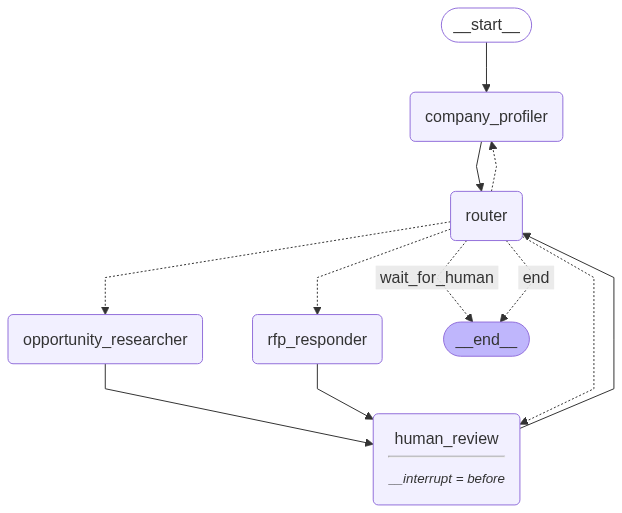

🤖 RFP Assistant Started!
Let's start by building your company profile. Please provide:
1. Company name
2. Core capabilities/services
3. Team size
4. Previous relevant experience
5. Geographic focus
6. Preferred contract value range

Simulating user input...

User Input: 
    Company: TechSolutions Inc.
    We specialize in cloud migration, API development, security compliance, and healthcare IT.
    Team size: 15 professionals
    Located in Ontario
    Previous experience with Health Canada projects
    

Assistant: Let's start by building your company profile. Please provide:
1. Company name
2. Core capabilities/services
3. Team size
4. Previous relevant experience
5. Geographic focus
6. Preferred contract value range

User Input: 1

Assistant: Let's start by building your company profile. Please provide:
1. Company name
2. Core capabilities/services
3. Team size
4. Previous relevant experience
5. Geographic focus
6. Preferred contract value range


In [3]:
import os
from typing import Dict, List, Any, Optional, TypedDict, Annotated
from datetime import datetime, timedelta
import json
import asyncio

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
import operator
from IPython.display import Image, display

# State definition for the RFP Assistant
class RFPAssistantState(TypedDict):
    messages: Annotated[List[Dict], operator.add]
    company_profile: Optional[Dict[str, Any]]
    opportunities: List[Dict[str, Any]]
    selected_opportunity: Optional[Dict[str, Any]]
    analysis_results: List[Dict[str, Any]]
    rfp_responses: Dict[str, Any]
    current_step: str
    human_feedback: Optional[str]
    iteration_count: int

# Mock data sources (in production, replace with real APIs)
MOCK_OPPORTUNITIES = [
    {
        "id": "RFP-2024-001",
        "title": "Digital Transformation Services for Healthcare",
        "agency": "Health Canada",
        "province": "ON",
        "value": "$2.5M - $5M CAD",
        "close_date": "2024-12-15",
        "requirements": ["Cloud migration", "API development", "Security compliance", "Healthcare experience"],
        "description": "Seeking comprehensive digital transformation services for modernizing healthcare data systems.",
        "source": "SAP (System for Award and Procurement)",
        "url": "https://sap.gov.ca/rfp-2024-001"
    },
    {
        "id": "RFP-2024-002", 
        "title": "AI-Powered Data Analytics Platform",
        "agency": "Statistics Canada",
        "province": "ON",
        "value": "$1M - $3M CAD",
        "close_date": "2024-11-30",
        "requirements": ["Machine Learning", "Data visualization", "Python/R", "Statistical analysis"],
        "description": "Development of AI-powered analytics platform for census data processing.",
        "source": "MERX",
        "url": "https://merx.com/rfp-2024-002"
    },
    {
        "id": "RFP-2024-003",
        "title": "Cybersecurity Assessment Services",
        "agency": "Public Safety Canada",
        "province": "BC",
        "value": "$500K - $1.5M CAD",
        "close_date": "2024-12-01",
        "requirements": ["Penetration testing", "Security audits", "Compliance frameworks", "Risk assessment"],
        "description": "Comprehensive cybersecurity assessment for critical infrastructure systems.",
        "source": "BuyandSell.gc.ca",
        "url": "https://buyandsell.gc.ca/rfp-2024-003"
    }
]

# Tools for the RFP Assistant
@tool
def search_canadian_rfps(query: str, province: str = "", value_range: str = "") -> List[Dict]:
    """
    Search for Canadian RFPs and procurement opportunities.
    
    Args:
        query: Search terms related to services/technology
        province: Optional province filter (ON, BC, QC, etc.)
        value_range: Optional contract value range
    """
    # In production, this would integrate with real APIs like:
    # - SAP (System for Award and Procurement)
    # - MERX
    # - BuyandSell.gc.ca
    # - Provincial procurement sites
    
    filtered_opps = []
    for opp in MOCK_OPPORTUNITIES:
        if query.lower() in opp['title'].lower() or query.lower() in opp['description'].lower():
            if not province or opp['province'] == province.upper():
                filtered_opps.append(opp)
    
    return filtered_opps

@tool 
def calculate_fit_score(company_capabilities: List[str], rfp_requirements: List[str]) -> Dict:
    """
    Calculate how well a company fits an RFP based on capabilities vs requirements.
    
    Args:
        company_capabilities: List of company's technical capabilities
        rfp_requirements: List of RFP requirements
    """
    matches = set(company_capabilities) & set(rfp_requirements)
    fit_percentage = (len(matches) / len(rfp_requirements)) * 100 if rfp_requirements else 0
    
    return {
        "fit_percentage": round(fit_percentage, 1),
        "matched_requirements": list(matches),
        "missing_requirements": [req for req in rfp_requirements if req not in company_capabilities],
        "recommendation": "High fit" if fit_percentage >= 70 else "Medium fit" if fit_percentage >= 40 else "Low fit"
    }

@tool
def generate_rfp_section(section_name: str, requirements: str, company_info: Dict) -> str:
    """
    Generate a specific section of an RFP response.
    
    Args:
        section_name: Name of the RFP section (e.g., "Technical Approach", "Team Structure")
        requirements: Requirements for this section
        company_info: Company information and capabilities
    """
    # This would use a more sophisticated prompt and company knowledge base
    templates = {
        "executive_summary": f"""
        Based on {company_info.get('name', 'our company')}'s expertise in {', '.join(company_info.get('capabilities', []))}, 
        we propose a comprehensive solution addressing the key requirements: {requirements}.
        Our approach leverages proven methodologies and experienced professionals to deliver exceptional results.
        """,
        "technical_approach": f"""
        Our technical approach incorporates industry best practices and leverages our expertise in {', '.join(company_info.get('capabilities', []))}.
        We will address the requirements through: {requirements}
        Our methodology ensures scalable, secure, and maintainable solutions.
        """,
        "team_structure": f"""
        Our project team consists of certified professionals with extensive experience in relevant technologies.
        Team size: {company_info.get('team_size', 'TBD')} professionals
        Key roles include project management, technical leads, and subject matter experts.
        """
    }
    
    return templates.get(section_name.lower().replace(" ", "_"), f"Section content for {section_name}: {requirements}")

# LangGraph nodes
def company_profiler_node(state: RFPAssistantState):
    """Node to collect and structure company information"""
    messages = state.get("messages", [])
    
    if not state.get("company_profile"):
        return {
            "messages": messages + [{
                "role": "assistant", 
                "content": "Let's start by building your company profile. Please provide:\n1. Company name\n2. Core capabilities/services\n3. Team size\n4. Previous relevant experience\n5. Geographic focus\n6. Preferred contract value range"
            }],
            "current_step": "awaiting_company_info"
        }
    
    return {"current_step": "company_profiled"}

def opportunity_researcher_node(state: RFPAssistantState):
    """Node to research and find relevant RFP opportunities"""
    company_profile = state.get("company_profile", {})
    
    if not company_profile:
        return {"current_step": "need_company_profile"}
    
    # Search for opportunities based on company capabilities
    capabilities = company_profile.get("capabilities", [])
    search_query = " ".join(capabilities[:3])  # Use top 3 capabilities
    province = company_profile.get("province", "")
    
    opportunities = search_canadian_rfps(search_query, province)
    
    # Calculate fit scores for each opportunity
    analysis_results = []
    for opp in opportunities:
        fit_analysis = calculate_fit_score(capabilities, opp["requirements"])
        analysis_results.append({
            "opportunity": opp,
            "fit_analysis": fit_analysis
        })
    
    # Sort by fit score
    analysis_results.sort(key=lambda x: x["fit_analysis"]["fit_percentage"], reverse=True)
    
    return {
        "opportunities": opportunities,
        "analysis_results": analysis_results,
        "current_step": "opportunities_found"
    }

def human_review_node(state: RFPAssistantState):
    """Node for human review and feedback"""
    current_step = state.get("current_step")
    
    if current_step == "opportunities_found":
        analysis_results = state.get("analysis_results", [])
        
        summary = "🔍 **RFP Opportunities Found:**\n\n"
        for i, result in enumerate(analysis_results[:5], 1):  # Show top 5
            opp = result["opportunity"]
            fit = result["fit_analysis"]
            summary += f"**{i}. {opp['title']}**\n"
            summary += f"   • Agency: {opp['agency']}\n"
            summary += f"   • Value: {opp['value']}\n"
            summary += f"   • Close Date: {opp['close_date']}\n"
            summary += f"   • Fit Score: {fit['fit_percentage']}% ({fit['recommendation']})\n"
            summary += f"   • Source: {opp['source']}\n\n"
        
        summary += "\nPlease select which opportunity you'd like to bid on (1-5), or ask for more details about any opportunity."
        
        return {
            "messages": state.get("messages", []) + [{"role": "assistant", "content": summary}],
            "current_step": "awaiting_selection"
        }
    
    return {"current_step": "human_review_complete"}

def rfp_responder_node(state: RFPAssistantState):
    """Node to help generate RFP responses"""
    selected_opp = state.get("selected_opportunity")
    company_profile = state.get("company_profile", {})
    
    if not selected_opp:
        return {"current_step": "need_opportunity_selection"}
    
    # Generate different sections of the RFP response
    sections = {
        "executive_summary": generate_rfp_section(
            "Executive Summary", 
            ", ".join(selected_opp["requirements"]), 
            company_profile
        ),
        "technical_approach": generate_rfp_section(
            "Technical Approach",
            ", ".join(selected_opp["requirements"]),
            company_profile
        ),
        "team_structure": generate_rfp_section(
            "Team Structure",
            f"Project for {selected_opp['title']}",
            company_profile
        )
    }
    
    return {
        "rfp_responses": sections,
        "current_step": "rfp_draft_ready"
    }

def router_node(state: RFPAssistantState):
    """Router to determine next step based on current state"""
    current_step = state.get("current_step", "start")
    
    next_step = "end"  # Default fallback

    if current_step == "start":
        next_step = "company_profiler"
    elif current_step == "awaiting_company_info":
        next_step = "wait_for_human"
    elif current_step == "company_profiled":
        next_step = "opportunity_researcher"
    elif current_step == "opportunities_found":
        next_step = "human_review"
    elif current_step == "awaiting_selection":
        next_step = "wait_for_human"
    elif current_step == "opportunity_selected":
        next_step = "rfp_responder"
    elif current_step == "rfp_draft_ready":
        next_step = "human_review"
    
    return {"current_step": next_step}


# Build the LangGraph workflow
def create_rfp_assistant_graph():
    workflow = StateGraph(RFPAssistantState)
    
    # Add nodes
    workflow.add_node("company_profiler", company_profiler_node)
    workflow.add_node("opportunity_researcher", opportunity_researcher_node)
    workflow.add_node("human_review", human_review_node)
    workflow.add_node("rfp_responder", rfp_responder_node)
    workflow.add_node("router", router_node)
    
    # Add edges
    workflow.add_edge(START, "company_profiler")
    workflow.add_edge("company_profiler", "router")
    workflow.add_edge("opportunity_researcher", "human_review")
    workflow.add_edge("human_review", "router")
    workflow.add_edge("rfp_responder", "human_review")
    
    # Conditional edges from router
    workflow.add_conditional_edges(
        "router",
        lambda state: state["current_step"],  # Now safe because router always returns dict
        {
            "company_profiler": "company_profiler",
            "opportunity_researcher": "opportunity_researcher", 
            "rfp_responder": "rfp_responder",
            "human_review": "human_review",
            "wait_for_human": END,  # Or handle separately depending on use case
            "end": END
        }
    )

    
    # Add memory for state persistence
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory, interrupt_before=["human_review"])
    # View
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
    
    return app

# Main RFP Assistant class
class RFPAssistant:
    def __init__(self):
        self.app = create_rfp_assistant_graph()
        self.thread_id = "rfp_session_1"
    
    def start_session(self):
        """Start a new RFP assistant session"""
        config = {"configurable": {"thread_id": self.thread_id}}
        
        initial_state = {
            "messages": [],
            "current_step": "start",
            "iteration_count": 0
        }
        
        # Run until first human interaction point
        result = self.app.invoke(initial_state, config)
        return result
    
    def process_human_input(self, user_input: str):
        """Process human input and continue the workflow"""
        config = {"configurable": {"thread_id": self.thread_id}}
        
        # Get current state
        current_state = self.app.get_state(config).values
        
        # Parse user input based on current step
        if current_state.get("current_step") == "awaiting_company_info":
            # Parse company information
            company_profile = self._parse_company_info(user_input)
            current_state["company_profile"] = company_profile
            current_state["current_step"] = "company_profiled"
            
        elif current_state.get("current_step") == "awaiting_selection":
            # Parse opportunity selection
            try:
                selection_num = int(user_input.strip()) - 1
                analysis_results = current_state.get("analysis_results", [])
                if 0 <= selection_num < len(analysis_results):
                    current_state["selected_opportunity"] = analysis_results[selection_num]["opportunity"]
                    current_state["current_step"] = "opportunity_selected"
            except (ValueError, IndexError):
                pass
        
        # Add user message
        current_state["messages"].append({"role": "user", "content": user_input})
        
        # Continue workflow
        result = self.app.invoke(current_state, config)
        return result
    
    def _parse_company_info(self, text: str) -> Dict[str, Any]:
        """Parse company information from user input"""
        # Simple parsing - in production, use NLP for better extraction
        lines = text.strip().split('\n')
        
        company_profile = {
            "name": "User Company",
            "capabilities": [],
            "team_size": "10-20",
            "province": "ON",
            "value_range": "$500K - $2M"
        }
        
        # Extract capabilities (keywords)
        text_lower = text.lower()
        capability_keywords = [
            "cloud", "api", "security", "healthcare", "machine learning", 
            "data analytics", "python", "cybersecurity", "ai", "digital transformation"
        ]
        
        for keyword in capability_keywords:
            if keyword in text_lower:
                company_profile["capabilities"].append(keyword.title())
        
        return company_profile
    
    def get_rfp_response_draft(self):
        """Get the current RFP response draft"""
        config = {"configurable": {"thread_id": self.thread_id}}
        current_state = self.app.get_state(config).values
        return current_state.get("rfp_responses", {})

# Example usage
if __name__ == "__main__":
    # Initialize the RFP Assistant
    assistant = RFPAssistant()
    
    print("🤖 RFP Assistant Started!")
    print("=" * 50)
    
    # Start the session
    result = assistant.start_session()
    
    # Print initial message
    if result.get("messages"):
        print(result["messages"][-1]["content"])
    
    # Simulate user interactions
    print("\n" + "=" * 50)
    print("Simulating user input...")
    
    # Company profile input
    company_info = """
    Company: TechSolutions Inc.
    We specialize in cloud migration, API development, security compliance, and healthcare IT.
    Team size: 15 professionals
    Located in Ontario
    Previous experience with Health Canada projects
    """
    
    print(f"\nUser Input: {company_info}")
    result = assistant.process_human_input(company_info)
    
    if result.get("messages"):
        print(f"\nAssistant: {result['messages'][-1]['content']}")
    
    # Opportunity selection
    print(f"\nUser Input: 1")
    result = assistant.process_human_input("1")
    
    if result.get("messages"):
        print(f"\nAssistant: {result['messages'][-1]['content']}")
    
    # Show RFP draft
    draft = assistant.get_rfp_response_draft()
    if draft:
        print("\n" + "=" * 50)
        print("📄 RFP Response Draft Generated:")
        for section, content in draft.items():
            print(f"\n**{section.upper()}:**")
            print(content.strip())

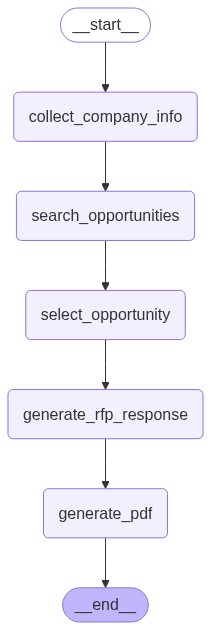

In [2]:
import uuid
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from fastapi.staticfiles import StaticFiles
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Optional, List

from nodes import (
    collect_company_info_node,
    search_opportunities_node,
    select_opportunity_node,
    generate_rfp_response_node,
    generate_pdf_node,
)

# Define RFP flow state type
class RFPState(TypedDict):
    company_info: Optional[dict]
    opportunities: Optional[List[dict]]
    selected_opportunity: Optional[dict]
    draft_response: Optional[str]
    pdf_path: Optional[str]

# Build LangGraph flow
builder = StateGraph(RFPState)
builder.set_entry_point("collect_company_info")

builder.add_node("collect_company_info", collect_company_info_node)
builder.add_node("search_opportunities", search_opportunities_node)
builder.add_node("select_opportunity", select_opportunity_node)
builder.add_node("generate_rfp_response", generate_rfp_response_node)
builder.add_node("generate_pdf", generate_pdf_node)

builder.add_edge("collect_company_info", "search_opportunities")
builder.add_edge("search_opportunities", "select_opportunity")
builder.add_edge("select_opportunity", "generate_rfp_response")
builder.add_edge("generate_rfp_response", "generate_pdf")
builder.add_edge("generate_pdf", END)

memory = MemorySaver()
graph = builder.compile()
# View
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

app = FastAPI(title="LangGraph-based Canadian RFP Assistant")

# Enable CORS for all origins
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Serve generated PDFs directory as static files
app.mount("/generated_pdfs", StaticFiles(directory="generated_pdfs"), name="generated_pdfs")

@app.post("/run-rfp-assistant")
async def run_rfp_assistant(company: dict):
    """
    Run full LangGraph flow:
    1) Accept company info
    2) Search opportunities
    3) Wait for client to provide selected opportunity in state (human in loop)
    4) Generate RFP draft
    5) Generate PDF
    Returns final state including pdf_path.
    """
    session_id = str(uuid.uuid4())
    initial_state = {"company_info": company}
    # Stream flow and get last output state
    result = await graph.astream(initial_state, config={"configurable": {"thread_id": session_id}}, stream_mode="values").areduce(lambda _, x: x)
    return result

if __name__ == "__main__":
    import uvicorn
    # uvicorn.run(app, host="0.0.0.0", port=5007)
